**Student ID**: 0900086089\
**Complete Name**: Pietro Cestola\
**Istitutional Mail**: pietro.cestola@studio.unibo.it

# Setup

## Google Drive

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Folder Path
Replace `YOUR_FOLDER_PATH` with the path where this file is located

In [2]:
#%cd /content/drive/MyDrive/YOUR_FOLDER_PATH
%cd /content/drive/MyDrive/ML4CV_assignment

/content/drive/MyDrive/ML4CV_assignment


## Dependencies
Install the `torchmetrics` library, used for evaluating segmentation metrics, and import all necessary packages and custom functions and modules.

In [ ]:
!pip install -q torchmetrics

the `network` folder is taken from the following [repository](https://git01lab.cs.univie.ac.at/est-gan/deeplabv3plus-pytorch/-/tree/master).

In [3]:
import os
import torch
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt

from tqdm import tqdm
from torch.utils.data import DataLoader

# External repository
import network as network

# Custom functions and classes
from lib.train import train, PrototypeHead, FocalLoss_Entropy
#from lib.test import msp_score, max_logit_score, entropy_score, energy_score, calculate_aupr, calculate_miou
from lib.data import class_to_name, ComposeSync, ToTensorSync, NormalizeSync, RandomCropSync, RandomHorizontalFlipSync, SegmentationDataset
from lib.utils import color, COLORS, plot_results, draw_barplot, draw_loss_barplot

## Model Weights

Download the model weights from Google drive (224,7 MB)

In [ ]:
!gdown -c 1h3oUMwKU5EZmmmiNrgs80ziLYbISYPVM -O ckpts/weights.pt

## Runtime Settings
Set torch device and reproducibility settings

In [4]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')
print(f"Using device: {device}")

Using device: cuda:0


In [5]:
def fix_random(seed: int):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

fix_random(seed=0)

# Dataset



## Overview
The StreetHazards dataset is a synthetic dataset specifically designed for anomaly detection in semantic segmentation tasks, with a particular focus on autonomous driving scenarios. It is created using a virtual simulation environment, where unexpected objects (i.e., objects not included in the pre-defined classes seen during training), also known as anomalies, are introduced.

### Dataset Composition:
- **Training Set**: Contains 5,125 images of road scenes without anomalies.
  
- **Validation Set**: Consists of 1,031 images of road scenes without anomalies.
  
- **Test Set**: Includes 1,500 images, where anomalies are explicitly introduced.


## Download
Download and extract the dataset (11GB)

In [ ]:
%%script echo skipping
!mkdir -p data
!wget -nc 'https://people.eecs.berkeley.edu/~hendrycks/streethazards_test.tar' -O './data/streethazards_test.tar'
!wget -nc 'https://people.eecs.berkeley.edu/~hendrycks/streethazards_train.tar' -O './data/streethazards_train.tar'
!tar -xf './data/streethazards_test.tar' -C './data'
!tar -xf './data/streethazards_train.tar' -C './data'

## Metrics

### Closed-Set Segmentation
In closed-set segmentation, only the known classes are considered; anomalous pixels are not counted. The performance metric used is the mIoU (mean Intersection over Union), which is obtained by averaging the IoU for each class. IoU is defined as the ratio between the area of overlap and the area of union of the predicted and ground truth masks.

### Anomaly Segmentation
The anomaly segmentation task is treated as a binary classification problem, where each pixel is classified as either anomalous or non-anomalous. Here, the approach with a score function applied to the raw logits is used to compute an anomaly score for each pixel, a threshold determines its classification.

The performance metric used, independent of the threshold selection, is the AUPR (Area Under the Precision-Recall Curve), which is computed as follows:
1. Order the pixels by their anomaly scores in descending order.
2. Calculate precision and recall at various threshold levels.
3. Integrate the resulting precision-recall curve to obtain the AUPR score.

Let $ l_i $ denote the logits produced by the model for a pixel, and $ p_i $ the probabilities obtained by applying the softmax function to the logits. Standard score functions include:
1. Maximum Softmax Probability: $ -\max{p_i} $
2. Maximum Logit: $ -\max{l_i} $
3. Energy: $ -\log{\sum{\exp{l_i}}} $


# Training

## Dataset
The dataset is loaded using the custom `SegmentationDataset` class, which ensures consistency between the transformations applied to image-mask pairs. For training, the following augmentations are applied:
- Random cropping (512×512)
- Horizontal flipping (p = 0.5)
- Normalization

For validation, only normalization is applied to the data.


In [ ]:
%%script echo skipping
# Paths to train and validation images and masks
path_train = os.path.join(os.getcwd(), 'data', 'train')
path_train_images =  os.path.join(path_train, 'images', 'training', 't1-3')
path_valid_images =  os.path.join(path_train, 'images', 'validation', 't4')
path_train_masks =  os.path.join(path_train, 'annotations', 'training', 't1-3')
path_valid_masks =  os.path.join(path_train, 'annotations', 'validation', 't4')

# Synchronized train transformations
train_transforms = ComposeSync([
    RandomCropSync((512,512)),
    RandomHorizontalFlipSync(p=0.5),
    ToTensorSync(),
    NormalizeSync(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Synchronized validation transformations
valid_transforms = ComposeSync([
  ToTensorSync(),
  NormalizeSync(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Training dataset
dataset_train = SegmentationDataset(
images_dirs = path_train_images,
masks_dirs = path_train_masks,
transforms = train_transforms
)

# Validation dataset
dataset_valid = SegmentationDataset(
images_dirs = path_valid_images,
masks_dirs = path_valid_masks,
transforms = valid_transforms
)

print(f"Training images: {len(dataset_train)}")
print(f"Validation images: {len(dataset_valid)}")

## Dataloader
Training and validation `Dataloaders` are created with a `batch_size` of `16`. Two worker threads are used for loading the data in parallel.

To ensure reproducibility, a fixed seed is set in:
- The worker initialization function
- The PyTorch generator

This guarantees that the results will be consistent across runs.

In [ ]:
%%script echo skipping
num_workers = 2
train_batch_size = 16
valid_batch_size = 16

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(0)

# Training DataLoader
dataloader_train = DataLoader(dataset_train,
                            batch_size=train_batch_size,
                            pin_memory=True,
                            num_workers=num_workers,
                            drop_last=True,
                            worker_init_fn=seed_worker,
                            generator=generator)
# Validation DataLoader
dataloader_valid = DataLoader(dataset_valid,
                            batch_size=valid_batch_size,
                            pin_memory=True,
                            num_workers=num_workers,
                            drop_last=True,
                            worker_init_fn=seed_worker,
                            generator=generator)

print(f"Training batches: {len(dataloader_train)}")
print(f"Validation batches: {len(dataloader_valid)}")

## Model

The project builds on **DeepLabv3+**, a state-of-the-art semantic segmentation architecture, using a **ResNet-101** backbone. The model is adapted to enhance its anomaly detection capabilities by modifying its classification head:

- **Prototype-Based Segmentation Head:** Instead of the standard convolutional classifier, a prototype-based segmentation head is used. For each known class, a learnable prototype vector $w_i$ is defined in the feature space. During the forward pass, the model computes pixel-wise logits as the negative Euclidean distance between the pixel’s feature vector and each class prototype. Denoting by $f$ the neural network up to the layer preceding the logits, the logit for class $i$ is given by:

  $$
  l_i(x) = -\| f(x; \theta) - w_i \|^2
  $$

- **Pre-trained Initialization:** To accelerate training and leverage prior knowledge, the **DeepLabv3+** backbone is initialized with weights pre-trained on the **Cityscapes** dataset. These pre-trained weights come from the following [repository](https://git01lab.cs.univie.ac.at/est-gan/deeplabv3plus-pytorch/-/tree/master).

- **Anomaly Detection Mechanism:** Anomaly detection is handled at inference by measuring prediction uncertainty. After obtaining the softmax probabilities for the known classes, the entropy of the probability distribution for each pixel is computed:

  $$
  H(p) = -\sum_{i=1}^{c} p_i \log p_i
  $$

  where $c$ is the number of known classes. High entropy indicates that the model is unsure and the pixel is likely an unknown object. This serves as the anomaly score for each pixel.


Download weights pre-trained on cityscapes (448,9 MB)

In [ ]:
%%script echo skipping
!gdown -c 1nmER-DVgFgpbwLN3rRlx0Hf_jqYRYdvc -O network/deeplabv3plus_resnet101_cityscapes.pt

Define the model

In [ ]:
%%script echo skipping
backbone = 'resnet101'
pre_train_dataset = 'cityscapes'

if pre_train_dataset == 'cityscapes':
    model = network.modeling.__dict__[f'deeplabv3plus_{backbone}'](num_classes=19, output_stride=16)
elif pre_train_dataset == 'voc':
    model = network.modeling.__dict__[f'deeplabv3plus_{backbone}'](num_classes=21, output_stride=16)

path = os.path.join(os.getcwd(), 'network', f'deeplabv3plus_{backbone}_{pre_train_dataset}.pt')
model.load_state_dict(torch.load(path, map_location=device))

model.classifier.classifier[3] = PrototypeHead(256, 13)

model.to(device)

## Hyperparameters & Optimization
Since the backbone is pre-trained, a lower learning rate prevents the weights from being updated too aggressively preserving its learned features.

In contrast, the classifier and the newly added head require more adaptation to the new dataset. Therefore, a higher learning rate is used for these components, allowing for faster convergence and better task-specific fine-tuning.

The class weights are computed as the inverse, rounded to the second decimal place, of the frequency of pixels belonging to each class in the training dataset.

In [12]:
%%script echo skipping
learning_rate = 1e-4
class_weights = False

# Optimizer
optimizer = torch.optim.Adam([
    {'params': model.backbone.parameters(),'lr': learning_rate * 0.1},
    {'params': model.classifier.parameters(),'lr': learning_rate}
], weight_decay=1e-4)

# Class weights
freq = torch.tensor([3.22, 8.32, 80.07, 214.23, 5441.09, 80.23, 74.35, 3.00,
                     14.90, 11.33, 404.04, 29.11, 995.08])
weights = (1/freq).to(device) if class_weights else None

## Loss

Training the model uses a combination of two loss terms to balance segmentation accuracy and confidence calibration:

- **Focal Loss**: Focal Loss is used instead of standard Cross-Entropy to address class imbalance and improve training focus on hard-to-segment pixels. The focusing parameter $\gamma$ is set to 2. This choice was made as the dataset is imbalanced across classes, and class weights did not provide satisfactory results.

- **Entropy Regularization**: An additional term proportional to the entropy of the softmax output is introduced to encourage confident predictions on known classes while promoting higher entropy for anomalies. Since the training data contain no anomalies, the model is explicitly penalized for producing high-entropy predictions on these images. In contrast, the expectation that anomalies will exhibit higher entropy is not enforced during training but relies on the assumption that the model will generalize in this way—an assumption that becomes less reliable near the boundaries of an anomalous object, where distinguishing between classes is spatially more challenging.

$$
  \mathcal{L} = \mathcal{L}_{\text{FL}} + \lambda H,
$$

The weighting factor $\lambda$ of the entropy regularization term is crucial. If set too high, it can lead to overconfident predictions and increased misclassification. Therefore, it was carefully tuned to optimize the model’s behavior. This aspect will be further discussed in the *Hyperparameter Tuning* section.

In [13]:
%%script echo skipping
gamma_focal   = 2.0
entropy_coeff = 1.0
criterion = FocalLoss_Entropy(gamma_focal, entropy_coeff, weights=weights)
criterion = criterion.to(device)

## Train
The model is trained for 50 `epochs` on the selected device, utilizing the training and validation dataloaders. Checkpoints are saved in the `ckpts` directory, with the run identified by `run_name`. A checkpoint is saved at each epoch if the validation loss improves. These checkpoints include not only the model weights but also the optimizer state, the scheduler state, and the best validation loss value, allowing training to resume if needed.  

The number of epochs and the scheduler were chosen based on an initial testing phase, guided by the validation loss and computational resource constraints, however this analysis is not included in the file.

In [ ]:
%%script echo skipping
epochs = 50
run_name = 'resnet101_distance_FLH_weights'
checkpoints_dir = os.path.join(os.getcwd(), 'ckpts')

train(model,
      criterion,
      optimizer,
      epochs,
      dataloader_train,
      dataloader_valid,
      device,
      run_name,
      checkpoints_dir)

# Hyperparameter Tuning

The following section explains the reasoning behind the training hyperparameter choices discussed earlier, focusing on their impact on model performance.  

The evaluation was conducted for both backbone architectures, using closed-set mIoU and AUPR for anomalies as the guiding metrics. All results are saved in the `tuning.csv` file and can be reproduced using the provided code, as explained in the README.

In [ ]:
df = pd.read_csv(os.path.join(os.getcwd(),'ckpts','tuning.csv'))

## Entropy Weight
The graph below shows that an `entropy weight` of `0.1` achieves the best performance in terms of mIoU, entropy AUPR, and msp AUPR for both backbones. Therefore, this value was chosen. The graph uses a `symlog` scale to properly handle the case where the entropy weight is 0.

The maxlog AUPR and energy AUPR metrics were not considered, as they proved to be less effective.

Beyond a certain point, increasing or decreasing the entropy weight leads to a drop in performance, as observed in the results. A very low weight preserves segmentation quality (mIoU) but weakens anomaly detection (AUPR metrics). Conversely, an excessively high weight forces overly confident predictions, degrading both segmentation quality and anomaly detection by reducing the entropy gap between normal and anomalous regions.


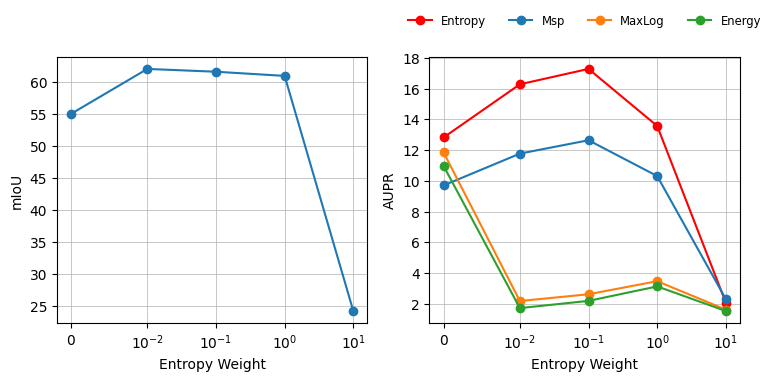

In [ ]:
plot_results(df, "gamma_focal==2.0 and backbone=='resnet101'", "entropy_weight", log_scale=True)

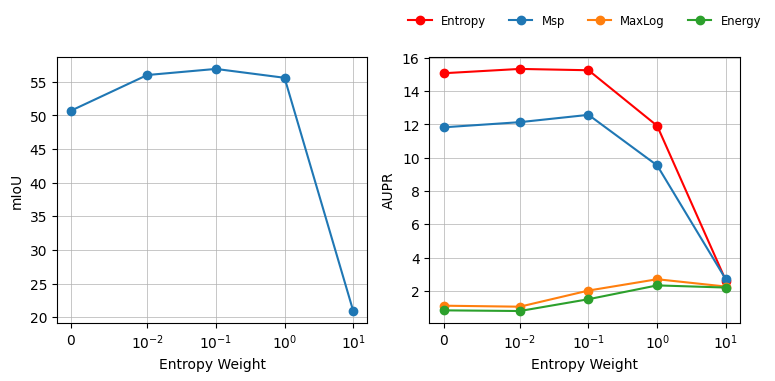

In [ ]:
plot_results(df, "gamma_focal==2.0 and backbone=='mobilenet'", "entropy_weight", log_scale=True)

## Focal Loss Focusing Parameter
The results did not indicate a strong preference focusing parameter value, except for $γ = 0$ (i.e., Cross-Entropy loss), which performed worse. Given the minimal differences observed in both closed-set mIoU and AUPR metrics, the standard gamma value of 2.0 was selected.


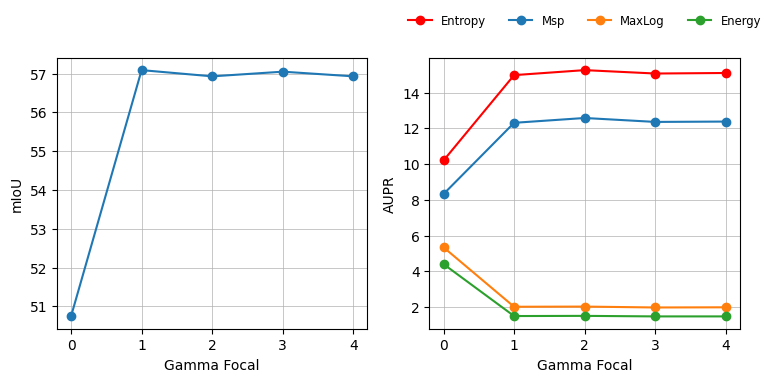

In [ ]:
plot_results(df, "entropy_weight==0.1 and backbone=='mobilenet'", "gamma_focal", log_scale=False)

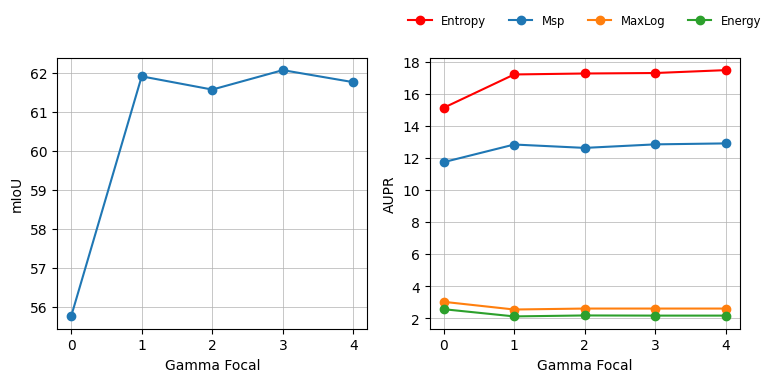

In [ ]:
plot_results(df, "entropy_weight==0.1 and backbone=='resnet101'", "gamma_focal", log_scale=False)

# Test

## Test Dataset
The StreetHazards test set is divided into two folders (t5 and t6). All test image folders are merged using `SegmentationDataset` custom class to form a single test dataset consisting of 1500 images. A synchronized transformation pipeline is applied, converting images and masks into tensors and normalizing the images.

In [ ]:
# Paths to test images and masks
path_test = os.path.join(os.getcwd(), 'data', 'test')
path_test_images_t5 =  os.path.join(path_test, 'images', 'test', 't5')
path_test_images_t6 =  os.path.join(path_test, 'images', 'test', 't6')
path_test_masks_t5 =  os.path.join(path_test, 'annotations', 'test', 't5')
path_test_masks_t6 =  os.path.join(path_test, 'annotations', 'test', 't6')

# Synchronized test transformations
transforms = ComposeSync([
    ToTensorSync(),
    NormalizeSync(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Test dataset
dataset_test = SegmentationDataset(
    images_dirs = [path_test_images_t5, path_test_images_t6],
    masks_dirs = [path_test_masks_t5, path_test_masks_t6],
    transforms = transforms
)

print(f"Test images: {len(dataset_test)}")

Test images: 1500


## Test Dataloader
Test `Dataloader` is created with a `batch_size` of `8`. Two worker threads are used for data loading. A fixed seed is set in both the worker initialization function and the PyTorch generator to ensure reproducibility.

In [ ]:
num_workers = 2
batch_size = 8

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

generator = torch.Generator()
generator.manual_seed(0)

# Test DataLoader
dataloader_test = DataLoader(dataset_test,
                            batch_size=batch_size,
                            pin_memory=True,
                            num_workers=num_workers,
                            worker_init_fn=seed_worker,
                            generator=generator)

print(f"Test batches: {len(dataloader_test)}")

Test batches: 188


Before computing the class-wise metrics, the following computation will confirm that Class 4 pixels (pedestrians) are not present in the test dataset. As a result, they are excluded from the calculation of the closed-set mIoU. To speed up execution, the corresponding code is skipped, and a predefined list is directly written in its place.

In [ ]:
%%script echo skipping
classes = torch.zeros(14, device=device)
with torch.no_grad():
  for _, masks in tqdm(dataloader_test, leave=False):
    masks = masks.to(device)
    classes[masks.unique()] = 1

miou_classes = classes.nonzero(as_tuple=True)[0].tolist()
miou_classes = miou_classes[:-1] # Remove anomaly class

print(miou_classes)

In [ ]:
miou_classes = [0,1,2,3,5,6,7,8,9,10,11,12]

## Load model
This cell initializes the DeepLabv3+ model with a ResNet-101 backbone and modifies its classification layer to use a `PrototypeHead` with 13 classes instead of the default 21. The model weights are then loaded from the `weights.pt` checkpoint and transferred to the selected device for inference.

In [ ]:
# Initialize DeepLabv3+ with MobileNet backbone
backbone = 'resnet101'
model = network.modeling.__dict__[f'deeplabv3plus_{backbone}'](num_classes=21, output_stride=16, pretrained_backbone=False)

# Replace the final classification layer
model.classifier.classifier[3] = PrototypeHead(num_features=256, num_classes=13)

# Load the trained model weights
path = os.path.join(os.getcwd(), 'ckpts', 'weights.pt')
model.load_state_dict(torch.load(path, map_location=device, weights_only=True))

model.to(device)
print(f"Model loaded on {device}")

## Qualitative Results

In [ ]:
#@title Closed-Set Segmentation { display-mode: "form" }
from ipywidgets import interact, IntSlider, FloatSlider

def update_visualization(index, entropy_threshold):
    """
    Updates the visualization with the test image, ground truth mask, entropy, and predicted mask.
    The predicted mask is updated based on the entropy threshold.
    """
    image, mask = dataset_test[index]

    image_disp = image.permute(1, 2, 0).numpy()
    image_disp = (image_disp - image_disp.min()) / (image_disp.max() - image_disp.min())

    mask_disp = mask.numpy()

    model.eval()
    with torch.no_grad():
        pred_mask = model(image.unsqueeze(0).to(device))
        pred_mask = torch.nn.functional.softmax(pred_mask.squeeze(0), dim=0).clamp(min=1e-10).cpu().numpy()
        entropy = -np.sum(pred_mask * np.log(pred_mask), axis=0) / np.log(pred_mask.shape[0])
        pred_mask = np.argmax(pred_mask, axis=0)
        pred_mask[entropy > entropy_threshold] = 13

    fig, axs = plt.subplots(1, 4, figsize=(24, 6))
    axs[0].imshow(image_disp)
    axs[0].axis('off')
    axs[0].set_title("Test Image")

    axs[1].imshow(color(mask_disp, COLORS))
    axs[1].axis('off')
    axs[1].set_title("Ground Truth Mask")

    axs[2].imshow(entropy)
    axs[2].axis('off')
    axs[2].set_title("Normalized Entropy")

    axs[3].imshow(color(pred_mask, COLORS))
    axs[3].axis('off')
    axs[3].set_title("Predicted Mask")

    plt.tight_layout(pad=3.0)
    plt.show()

index_slider = IntSlider(
    min=0,
    max=1499,
    step=1,
    value=1024,
    continuous_update=False,
    layout={'width': '80%'},
    description='Index:',
    style={'description_width': 'initial'}
)

entropy_slider = FloatSlider(
    min=0.0,
    max=1.0,
    step=0.01,
    value=0.75,
    continuous_update=False,
    layout={'width': '80%'},
    description='Entropy Threshold:',
    style={'description_width': 'initial'}
)

interact(update_visualization, index=index_slider, entropy_threshold=entropy_slider);

interactive(children=(IntSlider(value=1024, continuous_update=False, description='Index:', layout=Layout(width…

## Quantitative Results


### Closed-set mIoU
The IoU is first calculated for each class, and then the closed-set mIoU is computed by averaging the IoU values, excluding both the anomaly class and the pedestrian class, the latter for the reasons mentioned earlier.

In [ ]:
per_class_iou = calculate_miou(dataloader_test, model, device)
per_class_iou = per_class_iou[miou_classes]

In [ ]:
print("Per class IoU")
for c, iou in zip(miou_classes, per_class_iou):
    print(f"- {class_to_name[c]:14} {iou:.4f}")
print(f"mIoU: {per_class_iou.mean():.4f}")

Per class IoU
- unlabelled     0.8906
- building       0.7944
- fence          0.4264
- other          0.3610
- pole           0.3570
- road line      0.6368
- road           0.9629
- sidewalk       0.7193
- vegetation     0.8660
- car            0.7191
- wall           0.5578
- traffic sign   0.5207
mIoU: 0.6510


### Anomaly Segmentation  

Anomaly segmentation is a binary pixel classification task where each pixel is identified as either belonging to a known class or not (anomaly). Here anomalies are detected using entropy, on the softmax probabilities of logits, as the scoring function:  

$$
H(p) = -\sum_{i=1}^{c} p_i \log p_i
$$  

Higher entropy indicates greater uncertainty, making it an effective measure for identifying anomalous pixels. Performance is evaluated using Average Precision (AUPR), with entropy-based ranking used to construct the precision-recall curve.  

For computational efficiency, AUPR is approximated incrementally with a fixed number of bins for recall discretization, introducing an approximation error.

In [ ]:
entropy_aupr = calculate_aupr(dataloader_test, model, entropy_score, device, thresholds=1600)
print(f"Entropy AUPR: {entropy_aupr * 100:.2f}%")

Entropy AUPR: 17.30%


The entropy AUPR score reported in the table in the next subsection is slightly higher because it was obtained using the more precise version with automatic binning on a server:
```python
  entropy_aupr = calculate_aupr(dataloader_test, model, entropy_score, device, thresholds=None)
```
However, due to the dataset size, the calculation cannot be performed on Colab. Therefore, an approximation with 1,600 bins per class is used, the value of $17.37$ can be approached by increasing the number of bins.

## Comparison with literature
The table below compares the model's performance with several methods from recent literature on the StreetHazards for anomaly segmentation.

For a complete comparison, four different uncertainty metrics were tested: maximum softmax probability, maximum logit, entropy, and energy (logsumexp). Although entropy was ultimately chosen as the final metric, the table reports the best results obtained for the proposed method by varying model components and parameters.

In the table, `This work` refers to the architecture chosen at the end of the evaluation process. `This work (best)` indicates the highest score achieved across all model configurations.

| **Model**  | **mIoU** | **MSP AUPR** | **MAXLOGIT AUPR** | **ENTROPY AUPR** | **ENERGY AUPR** | **OTHER AUPR** |
| :-         | :-:      | :-:      | :-:      | :-:      | :-:      | :-:      |
| [Reference 1](https://arxiv.org/pdf/1911.11132)|-|-|10.6|-|-|
| [Reference 2](https://arxiv.org/pdf/2108.04562)|53.9|6.6|10.6|-|-| 14.7|
| [Reference 3](https://arxiv.org/pdf/2211.14512)|65.0|-|-|-|-|31.15|
| [Reference 4](https://arxiv.org/pdf/2207.02606v1)|63.0|7.5|-|-|12.9|30.2|
| [Reference 5](https://arxiv.org/pdf/2208.14195v1)|-|12.53|15.22|15.43|-|-|
| This work       |65.1|12.70|2.63|17.37|2.19|-|
| This work (best)|65.3|13.49|13.19|17.37|13.71|-|
                  

# Ablation Study

To assess the impact of different architectural and training choices, an **ablation study** was conducted, analyzing variations in the **backbone**, **pre-training dataset**, **classification head**, **class weights** and **loss function**. The pre-trained models used in this study were sourced from the following [repository](https://git01lab.cs.univie.ac.at/est-gan/deeplabv3plus-pytorch/-/tree/master).

- **Backbone:** Two encoder architectures, MobileNet (4.2 million parameters) and ResNet101 (44.5 million parameters), were tested to assess whether using a smaller model could be a reasonable choice compared to a larger and more complex one, evaluating their impact on segmentation performance.

- **Pre-Training Dataset:** For each backbone, two sets of pre-trained weights were tested: one trained on Cityscapes and the other on Pascal VOC, allowing an analysis of the impact of domain-specific pretraining.

- **Classification Head:** Two variants of the segmentation head were compared: the standard DeepLabv3+ convolutional head and the prototype-based head defined in the previous section.

- **Class Weights:** To account for class imbalance, experiments were conducted both with and without class weighting. When applied, the weights were computed using the inverse class frequency.

- **Loss Function:** Four loss formulations were considered to examine the influence of different training objectives. In addition to Cross-Entropy (CE) and Focal Loss (FL) (used to mitigate class imbalance), an entropy regularization term was introduced to push the model toward making confident predictions under the assumption that no anomalies are present in the training dataset. This results in the following four loss functions:


\begin{array}{cc}
\mathcal{L}_{\text{CE}} = -\sum{y_i \log{p_i}}&
\mathcal{L}_{\text{FL}} = -\sum{y_i (1-p_i)^{\gamma}\log{p_i}}\\
\mathcal{L}_{\text{CE+H}} = \mathcal{L}_{\text{CE}} + \lambda \mathcal{H}&
\mathcal{L}_{\text{FL+H}} = \mathcal{L}_{\text{FL}} + \lambda \mathcal{H}
\end{array}

## Ablation results
The file `ablation.csv` contains the results of the tests conducted, which will be presented below.

In [ ]:
df = pd.read_csv(os.path.join(os.getcwd(),'ckpts','ablation.csv'))

The following bar plots compare the performance of two models across different configurations. The plots visualize the values for a selected metric (e.g., mIoU, Entropy AUPR), with the x-axis ticks in red indicating the parameter being varied (e.g., "head" or "loss"). The bars represent the performance for each model under different settings, with each group shown side by side for direct comparison.

### Backbone
Regardless of the pre-training dataset (Cityscapes or Pascal VOC), ResNet101 consistently outperforms MobileNet, demonstrating that increasing computational capacity leads to improved segmentation performance, validating the effectiveness of deeper architectures in this task.

Although MobileNet is significantly lighter and more computationally efficient, the results do not support its selection, as the performance gap is too large to justify the trade-off in this specific task.

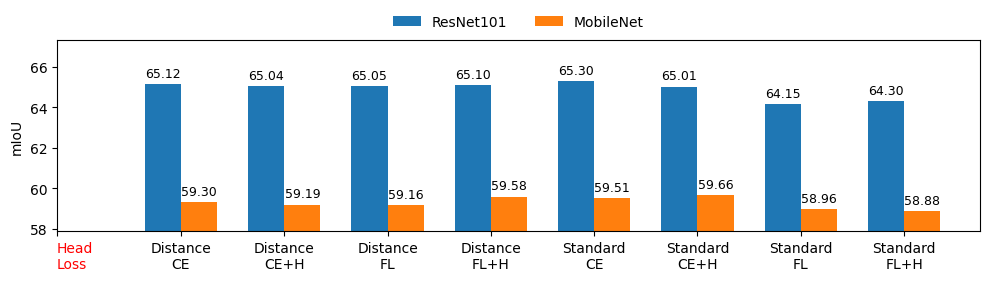

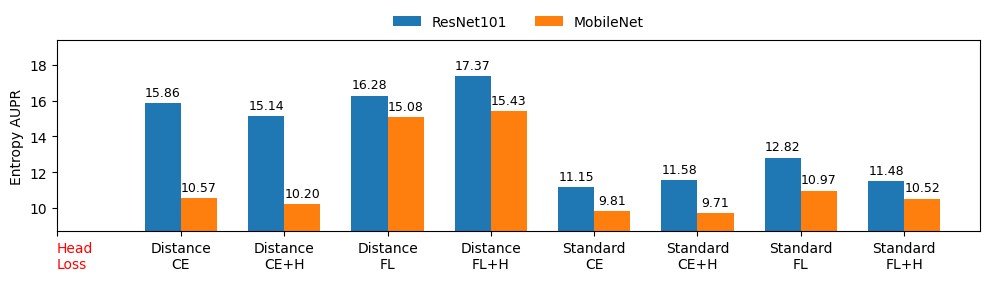

In [ ]:
comparison_params = ['head','loss']
query_group1 = "backbone=='resnet101' and dataset=='cityscapes' and class_weights==False"
query_group2 = "backbone=='mobilenet' and dataset=='cityscapes' and class_weights==False"
label_group1='ResNet101'
label_group2='MobileNet'

draw_barplot(df, 'mIoU', 'mIoU', comparison_params, query_group1, query_group2, label_group1, label_group2)
draw_barplot(df, 'entropy', 'Entropy AUPR', comparison_params, query_group1, query_group2, label_group1, label_group2)

### Pre-Training Dataset
A comparison between Cityscapes and VOC pre-training reveals that a backbone pre-trained on Cityscapes consistently achieves superior performance in both closed-set mIoU and anomaly AUPR. This highlights the benefits of task-specific pre-training on a dataset closely aligned with the target domain.

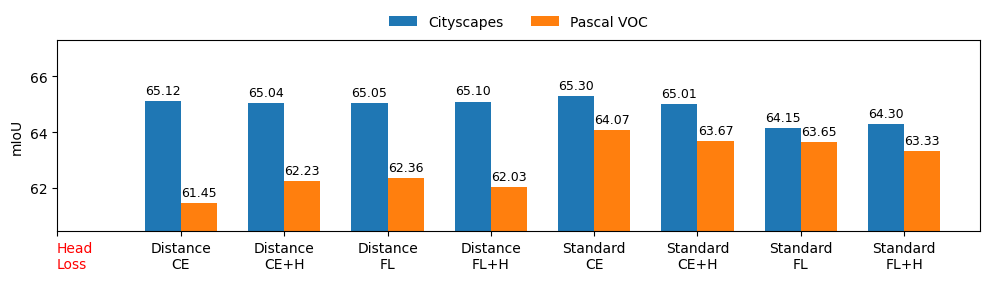

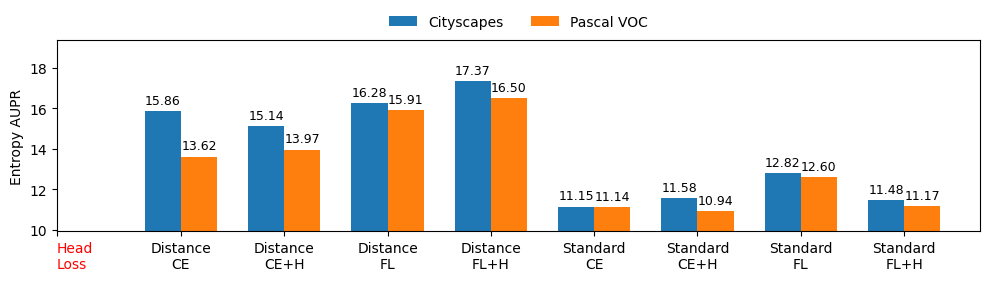

In [ ]:
comparison_params = ['head','loss']
query_group1 = "backbone=='resnet101' and dataset=='cityscapes' and class_weights==False"
query_group2 = "backbone=='resnet101' and dataset=='voc' and class_weights==False"
label_group1='Cityscapes'
label_group2='Pascal VOC'

draw_barplot(df, 'mIoU', 'mIoU', comparison_params, query_group1, query_group2, label_group1, label_group2)
draw_barplot(df, 'entropy', 'Entropy AUPR', comparison_params, query_group1, query_group2, label_group1, label_group2)

### Classification Head
Although the standard head and the distance-based prototype head perform almost identically in terms of closed-set mIoU, with slight variations favoring one or the other in different cases, the distance-based prototype head achieves significantly higher results in anomaly detection, when using the entropy score.

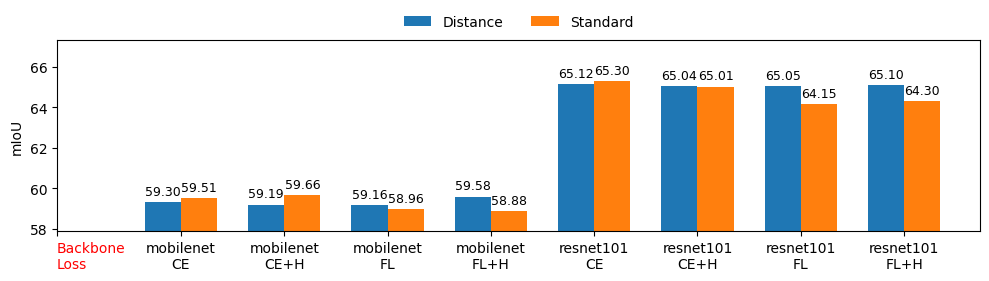

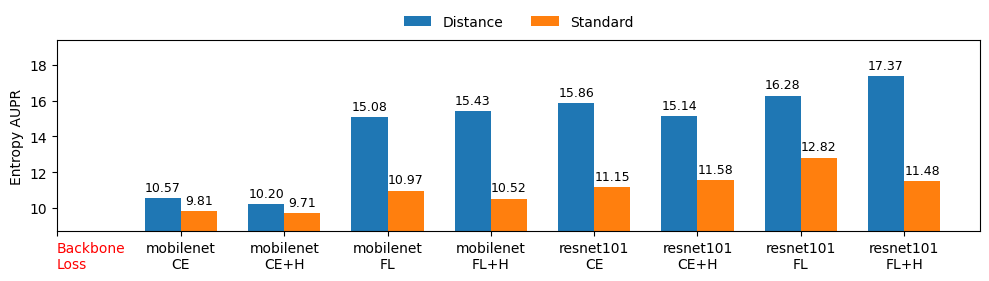

In [ ]:
comparison_params = ['backbone','loss']
query_group1 = "dataset=='cityscapes' and class_weights==False and head=='Distance'"
query_group2 = "dataset=='cityscapes' and class_weights==False and head=='Standard'"
label_group1='Distance'
label_group2='Standard'

draw_barplot(df, 'mIoU', 'mIoU', comparison_params, query_group1, query_group2, label_group1, label_group2)
draw_barplot(df, 'entropy', 'Entropy AUPR', comparison_params, query_group1, query_group2, label_group1, label_group2)

### Class Weights
The graph below shows that while the use of class weights improved minIoU (the lowest IoU value among classes), it negatively impacted both mIoU and AUPR. As a result, class weights were not used in the final model due to their adverse effect on these metrics.

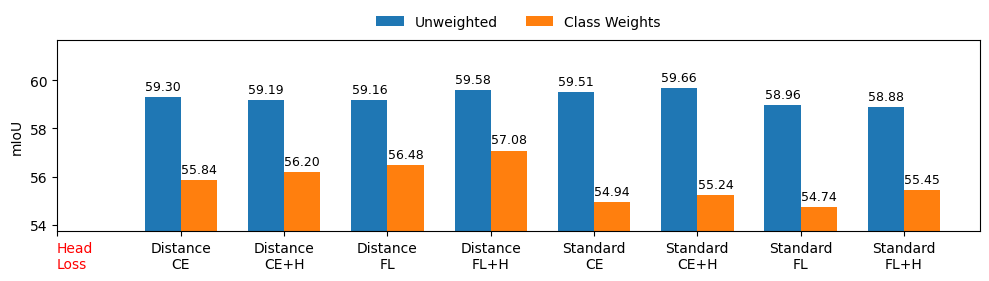

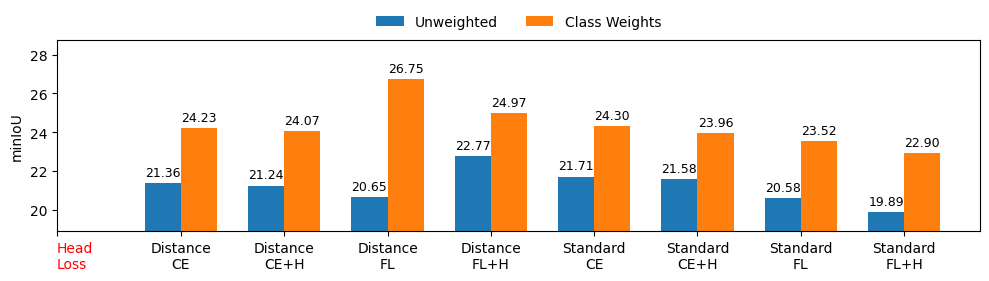

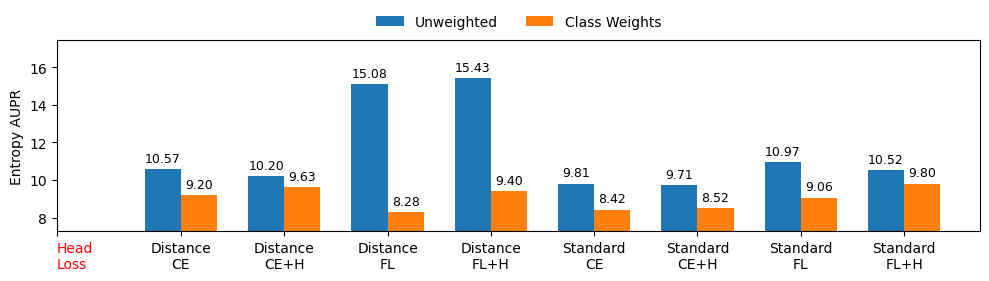

In [ ]:
comparison_params = ['head','loss']
query_group1 = "backbone=='mobilenet' and dataset=='cityscapes' and class_weights==False"
query_group2 = "backbone=='mobilenet' and dataset=='cityscapes' and class_weights==True"
label_group1='Unweighted'
label_group2='Class Weights'

draw_barplot(df, 'mIoU', 'mIoU', comparison_params, query_group1, query_group2, label_group1, label_group2)
draw_barplot(df, 'minIoU', 'minIoU', comparison_params, query_group1, query_group2, label_group1, label_group2)
draw_barplot(df, 'entropy', 'Entropy AUPR', comparison_params, query_group1, query_group2, label_group1, label_group2)

### Loss

The following bar plot compares the performance of the four loss functions across different uncertainty metrics. The comparison uses the chosen configuration: ResNet101 backbone pre-trained on the Cityscapes dataset without class weights, with the Distance-based Prototype Head.

Focal Loss with Entropy (FL+H) is the best-performing loss in terms of msp AUPR and entropy AUPR. Since entropy provides the highest scores among the metrics, FL+H leads to the highest overall score, and it was therefore selected.

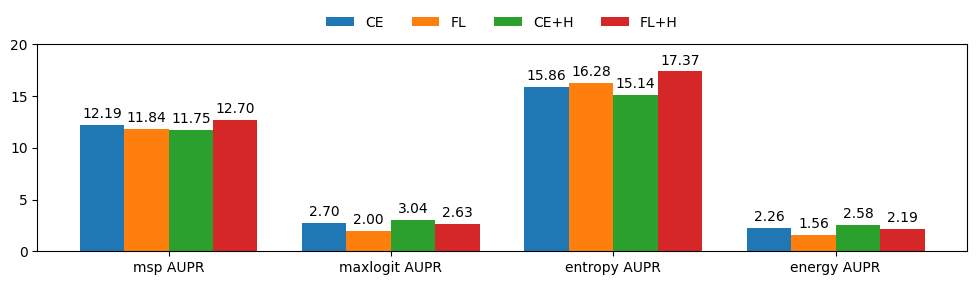

In [ ]:
query = "backbone=='resnet101' and dataset=='cityscapes' and class_weights==False and head=='Distance'"

draw_loss_barplot(df, query)

### How to Add Additional Graphs

You can use the `draw_barplot()` function to generate bar plots for different metrics by specifying the relevant parameters. If you want to visualize additional metrics or configurations, simply call the function with the corresponding arguments. Note that the function compares only two groups at a time.

Here's an example of how to use the function:
```python
draw_barplot(df, 'metric_name', 'y_axis_label', comparison_params, query_group1, query_group2, label_group1, label_group2)
```
where the parameters are:
- `df:` dataframe containing the data you want to plot.
- `metric_name:` metric in the columns of the dataframe.
- `y_axis_label:` label for the y-axis of the plot.
- `comparison_params:` a list of dataframe columns keys. The plot will show how the metric values change as these parameters are varied.
- `query_group1, query_group2` - query strings used to filter data for the two groups you want to compare.
- **`label_group1, label_group2`** - labels for the two groups being compared in the plot.

By calling the function with different metrics, you can generate and compare bar plots for various configurations and model performances, in addition to those already present.